In [1]:
import os
import cv2
import json
import torch
import numpy as np
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataset import CustomCombineTestDataset
from utils import set_seed, custom_combine_test_collate_fn


In [2]:
torch.cuda.empty_cache()
set_seed(31)

In [3]:
tf = A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(),
        ]
    )
valid_dataset = CustomCombineTestDataset(
        "/opt/ml/level3_cv_finalproject-cv-01/model",
        tf=tf,
    )
valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=256,
        shuffle=True,
        num_workers=8,
        collate_fn=custom_combine_test_collate_fn,
        drop_last=False,
    )

In [4]:
model = torch.load("/opt/ml/level3_cv_finalproject-cv-01/model/save/Tresnet_m_ml_decoder_recipy_latest.pth")
model.cuda()
model.eval()

Tresnet_m_ml_decoder_recipy(
  (model): TResNet(
    (body): Sequential(
      (s2d): SpaceToDepth()
      (conv1): ConvNormAct(
        (conv): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): ConvNormAct(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): LeakyReLU(negative_slope=0.001, inplace=True)
            )
          )
          (conv2): ConvNormAct(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [5]:
with torch.no_grad():
    images_path, gt, pred = np.array([]), np.array([]), np.array([])
    flag = False
    for image_path, images, labels in valid_loader:
        images = torch.tensor(images).cuda()
        outputs = model(images)

        outputs = F.sigmoid(outputs).cpu().numpy()
        outputs = (outputs >= 0.5)
        labels = (labels >= 0.5)
        # outputs = outputs.cpu().numpy()
        if flag:
            images_path = np.concatenate((images_path, image_path), axis=0)
            gt = np.concatenate((gt, labels), axis=0)
            pred = np.concatenate((pred, outputs), axis=0)
        else:
            images_path = image_path
            gt = labels
            pred = outputs
            flag = True

In [6]:
print(images_path.shape)
print(gt.shape)
print(pred.shape)

(18180,)
(18180, 110)
(18180, 110)


In [7]:
import pandas as pd

data = {"image_path":[], "gt":[], "pred":[]}
for image_path, label, p in zip(images_path, gt, pred):
    data["image_path"].append(image_path)
    data["gt"].append(label)
    data["pred"].append(p)

In [8]:
df = pd.DataFrame(data)

In [9]:
filename = 'output_true.csv'
df.to_csv(filename, index=False)

In [10]:
test_path = "/opt/ml/level3_cv_finalproject-cv-01/model/data/test_data"
file_list = []
for root, dirs, files in os.walk(test_path):
    for file in files:
        file_path = os.path.join(root, file)
        file_list.append(file_path)

In [32]:
i = 0
tf = A.Compose(
        [
            A.Resize(224, 224),
            A.Normalize(),
        ]
    )
with open("/opt/ml/level3_cv_finalproject-cv-01/model/data/classes.json") as file:
    classes_dict = json.load(file)
with open("/opt/ml/level3_cv_finalproject-cv-01/model/data/ingredients.json") as file:
    ingredients_dict = json.load(file)
classes = []
for label in classes_dict.values():
    classes.append(label)
for ingredient in ingredients_dict.values():
    classes.append(ingredient)

Predict class : ['chocolate', 'milk']


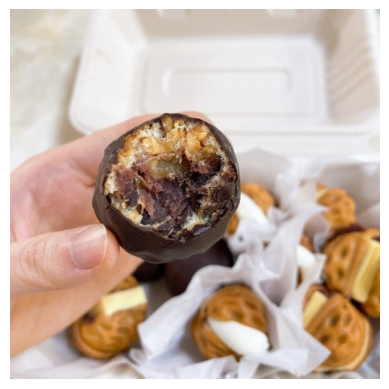

In [56]:
image = cv2.imread(file_list[i])
if tf is not None:
    inputs = {"image": image}
    result = tf(**inputs)

    images = result["image"]
images = images.transpose(2, 0, 1)
with torch.no_grad():
    images = torch.Tensor(images).cuda()
    images = images.unsqueeze(0)
    outputs = model(images)
    outputs = F.sigmoid(outputs).cpu().numpy()
    outputs = (outputs >= 0.5)
    pred = [classes[int(idx)] for idx, v in enumerate(outputs[0]) if v == True]
    print(f"Predict class : {pred}")
fig, ax = plt.subplots()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
i += 1
    